In [1]:
# Tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# FGSM: perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇ J(θ,x,y))

In [2]:
# import
import torch
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.data.all import (
    CategoryBlock,
    DataBlock,
    DataLoaders,
    RandomSplitter,
    RegressionBlock,
)

import fastai
from fastai.vision.all import *
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.data import ImageBlock, ImageDataLoaders
# from fastai.vision.learner import Learner, accuracy, vision_learner
# from fastai.vision.models import resnet18, resnet34
from fastai.vision.utils import get_image_files
from torch import nn
import torch.optim as optim
from fastai.vision.models import resnet18
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from math import radians

/home/cemb2020/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
fastai.__version__

'2.7.11'

In [4]:
# Assign GPU
torch.cuda.set_device(2)

print("Running on GPU: " + str(torch.cuda.current_device()))

Running on GPU: 2


In [5]:
# start a new wandb run to track this script
run = wandb.init(
        project="DataAugmentation",
        entity="arcslaboratory",
        notes="Adversarial Generation for Adversarial Training"
    )

wandb: Currently logged in as: christymnm (arcslaboratory). Use `wandb login --relogin` to force relogin
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)


In [6]:
def y_from_filename(rotation_threshold, filename) -> str:
    """Extracts the direction label from the filename of an image.

    Example: "path/to/file/001_000011_-1p50.png" --> "right"
    """
    filename_stem = Path(filename).stem
    angle = float(filename_stem.split("_")[2].replace("p", "."))

    if angle > rotation_threshold:
        return "left"
    elif angle < -rotation_threshold:
        return "right"
    else:
        return "forward"
        
def get_dls(data_path: str):
    # NOTE: not allowed to add a type annotation to the input

    image_filenames: list = get_image_files(data_path)  # type:ignore

    # Using a partial function to set the rotation_threshold from args
    label_func = partial(y_from_filename, radians(5))

    return ImageDataLoaders.from_name_func(
            data_path,
            image_filenames,
            label_func,
            valid_pct=0.2,
            bs=64)

def get_test_dls(data_path: str):
    # NOTE: not allowed to add a type annotation to the input

    image_filenames: list = get_image_files(data_path)  # type:ignore

    # Using a partial function to set the rotation_threshold from args
    label_func = partial(y_from_filename, radians(5))

    return ImageDataLoaders.from_name_func(
            data_path,
            image_filenames,
            label_func,
            valid_pct=.99,
            bs=64)

In [7]:
# get data
data_folder = "/home/cemb2020/scr2023/data/WanderingStaticTextures/"
# get model
models_folder = "/home/cemb2020/scr2023/data/WanderingStaticTextures/models/"
model_name = "wandering-static_rep00.pkl"

In [8]:
#learner = load_learner(models_folder + model_name, cpu=False)

In [9]:
dls = get_dls(data_folder)
learner = vision_learner(
            dls,
            resnet18,
            pretrained=True,
            metrics=accuracy,
            cbs=WandbCallback(log_model=True),
        )

/opt/mambaforge/envs/r_scr2023/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mambaforge/envs/r_scr2023/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.331428,2.500174,0.297619,00:26


Better model found at epoch 0 with valid_loss value: 2.500174045562744.


epoch,train_loss,valid_loss,accuracy,time
0,0.784195,0.584935,0.750000,00:28


Better model found at epoch 0 with valid_loss value: 0.5849352478981018.


In [11]:
learner.eval()
print("eval mode")

eval mode


In [12]:
epsilons = [0, .05]

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test(model, test_loader, epsilon):
    
    # Accuracy counter
    correct = 0
    adv_examples = []
    i = 0

    # Loop over all examples in test set
    for data, target in test_loader:
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = learner.model(data)
            
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        #print("real_prediction: " + str(target.item()) + "\ninit_pred:" + str(init_pred.item()))

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Apply softmax to the predictions so we can replace crossentropylossflat
        output_softmax = F.softmax(output, dim=1)
        # Calculate the loss
        loss = nn.CrossEntropyLoss()
        loss = loss(output_softmax, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = learner.model(perturbed_data)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # print("adversarial example generated")
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
accuracies = []
examples = []

image_filenames: list = get_image_files(data_folder)
test_loader = learner.dls.test_dl(image_filenames, bs=1, with_labels=True)
print(len(test_loader))

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(learner, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

1261
Epsilon: 0	Test Accuracy = 894 / 1261 = 0.7089611419508327
Epsilon: 0.05	Test Accuracy = 246 / 1261 = 0.1950832672482157


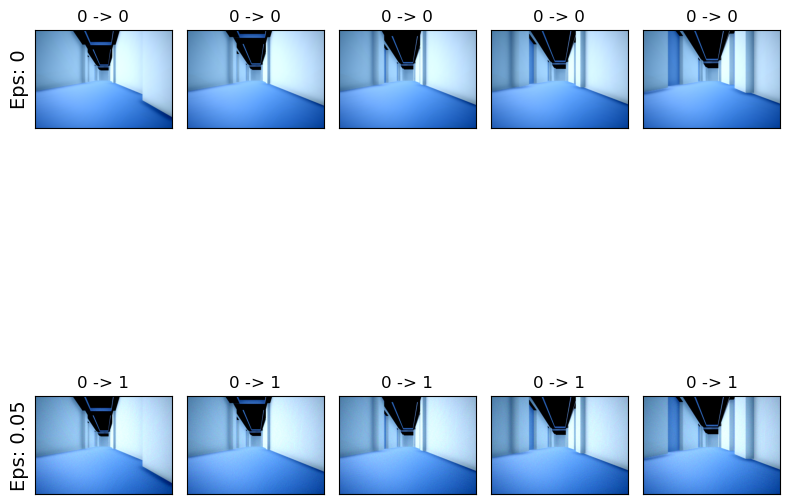

In [29]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        outmap_min = np.min(ex)
        outmap_max = np.max(ex)
        ex = (ex - outmap_min) / (outmap_max - outmap_min)
        plt.imshow((np.transpose(ex, (1, 2, 0))))
plt.tight_layout()
plt.show()

In [17]:
run = wandb.init(
    project="DataAugmentation",
    entity="arcslaboratory",
    notes="adversarial example generation",
)

if run is None:
    raise Exception("wandb.init() failed")

accuracy,▁█
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▂▃▄▄▅▆▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▂▂▂▃▄▄▅▆▆▇▇██▂▂▃▄▄▄▄▄▄▃▃▂▂▁▁
lr_2,▁▁▂▂▂▃▄▄▅▆▆▇▇██▂▂▃▄▄▄▄▄▄▃▃▂▂▁▁
mom_0,███▇▇▆▆▅▄▃▃▂▂▁▁█▇▅▃▁▁▁▂▃▄▅▆▇▇█
mom_1,███▇▇▆▆▅▄▃▃▂▂▁▁█▇▅▃▁▁▁▂▃▄▅▆▇▇█
mom_2,███▇▇▆▆▅▄▃▃▂▂▁▁█▇▅▃▁▁▁▂▃▄▅▆▇▇█


cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)
